In [1]:
#necessary imports
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "png"

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

# Part 1 : Exploratory Data Analysis

In [2]:
df_uber = pd.concat([pd.read_csv(f'data/uber-raw-data-{month}.csv') for month in ('apr14', 'may14', 'jun14', 'jul14', 'aug14', 'sep14')])
df_uber.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [3]:
df_zones = pd.read_csv('data/taxi-zone-lookup.csv')
df_zones.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [4]:
#preprocessing
df_uber['Date/Time'] = pd.to_datetime(df_uber['Date/Time'])
df_uber['Day'] = df_uber['Date/Time'].dt.day
df_uber['Hour'] = df_uber['Date/Time'].dt.hour
df_uber['Month'] = df_uber['Date/Time'].dt.month
df_uber['dayofweek'] = df_uber['Date/Time'].dt.dayofweek

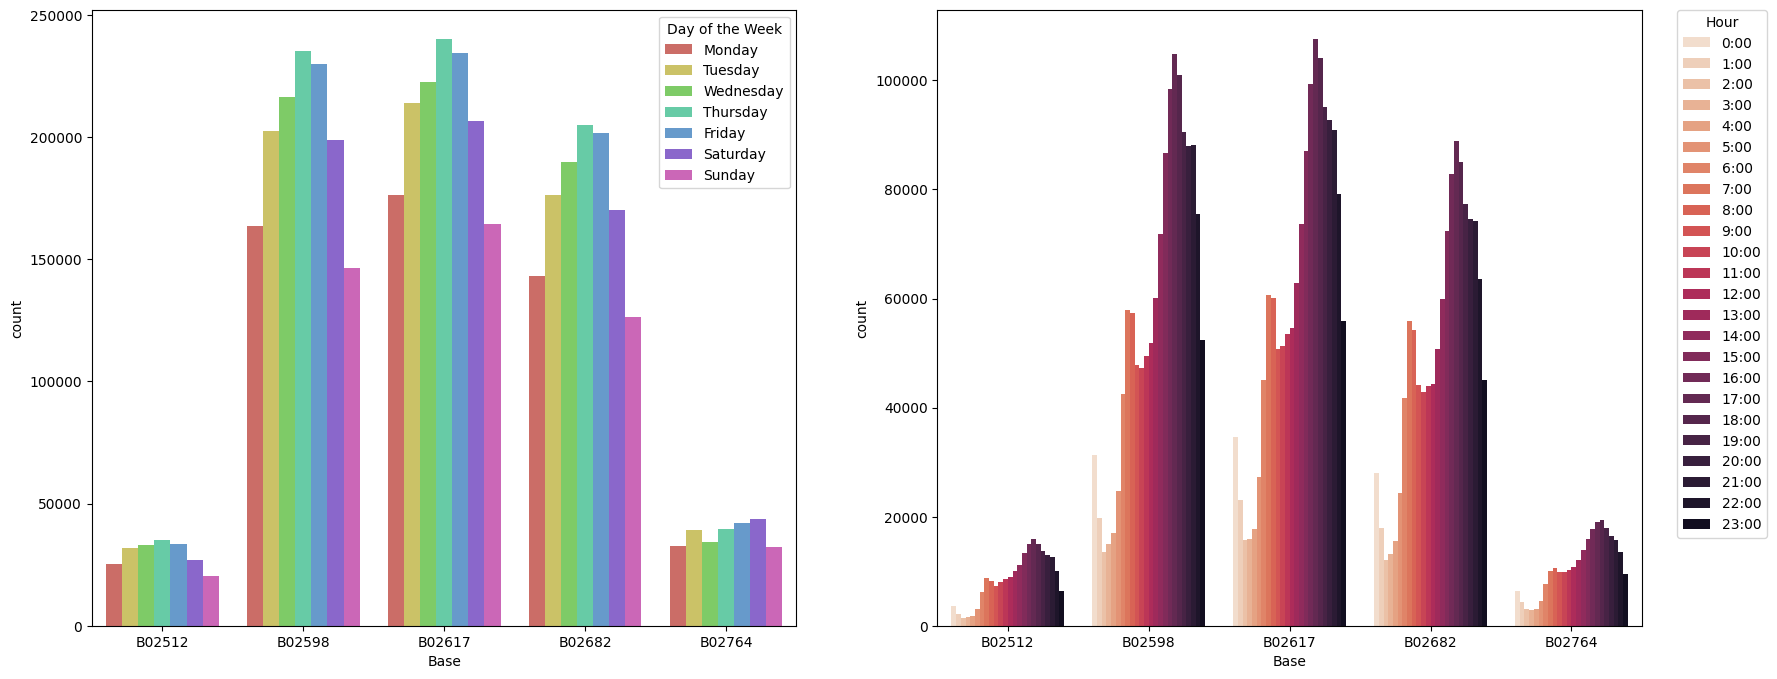

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,8))
sns.countplot(data=df_uber,x='Base',hue='dayofweek', ax=ax1, palette='hls')
ax1.legend(title='Day of the Week', labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sns.countplot(data=df_uber,x='Base',hue='Hour', ax=ax2, palette=sns.color_palette('rocket_r', 24))
ax2.legend(title='Hour', labels=[f'{i}:00' for i in range(24)], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [6]:
#implement week day and weekend
df_uber['weekend'] = df_uber['dayofweek'].apply(lambda x: 1 if x > 4 else 0)

#implement rush hour
df_uber['rush_hour'] = df_uber['Hour'].apply(lambda x: 1 if x in [7,8,9,16,17,18] else 0)

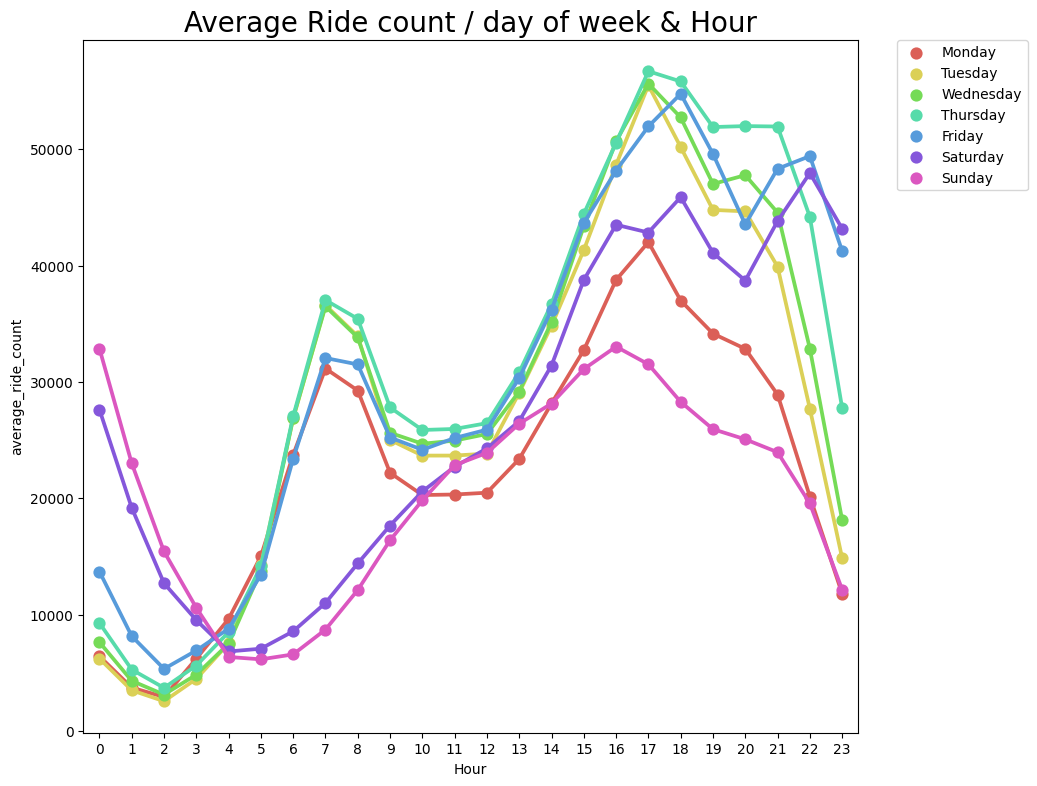

In [7]:
hourly_avg = df_uber.groupby(['Hour','dayofweek'])['Date/Time'].count().reset_index()
daily_hourly_avg = hourly_avg.groupby(['dayofweek','Hour'])['Date/Time'].mean().reset_index().rename(columns = {'Date/Time':'average_ride_count'})
daily_hourly_avg['dayofweek'] = daily_hourly_avg['dayofweek'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

plt.figure(figsize=(10,9))
sns.pointplot(x='Hour',y='average_ride_count',hue='dayofweek', data = daily_hourly_avg, palette='hls').set_title('Average Ride count / day of week & Hour', color='black', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

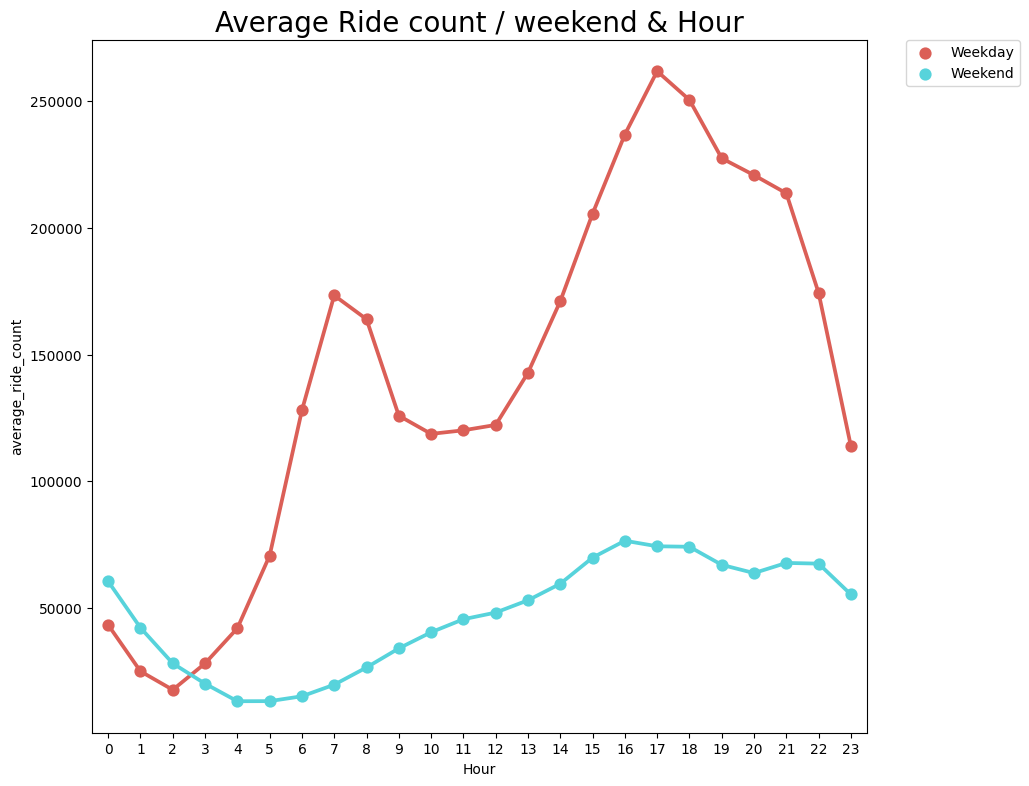

In [8]:
#average ride count by weekday and weekend
weekend_avg = df_uber.groupby(['weekend','Hour'])['Date/Time'].count().reset_index().rename(columns = {'Date/Time':'average_ride_count'})
weekend_avg['weekend'] = weekend_avg['weekend'].map({0:'Weekday', 1:'Weekend'})


#plotting average ride count by weekday and weekend
plt.figure(figsize=(10,9))
sns.pointplot(x='Hour',y='average_ride_count',hue='weekend', data = weekend_avg, palette='hls').set_title('Average Ride count / weekend & Hour', color='black', fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

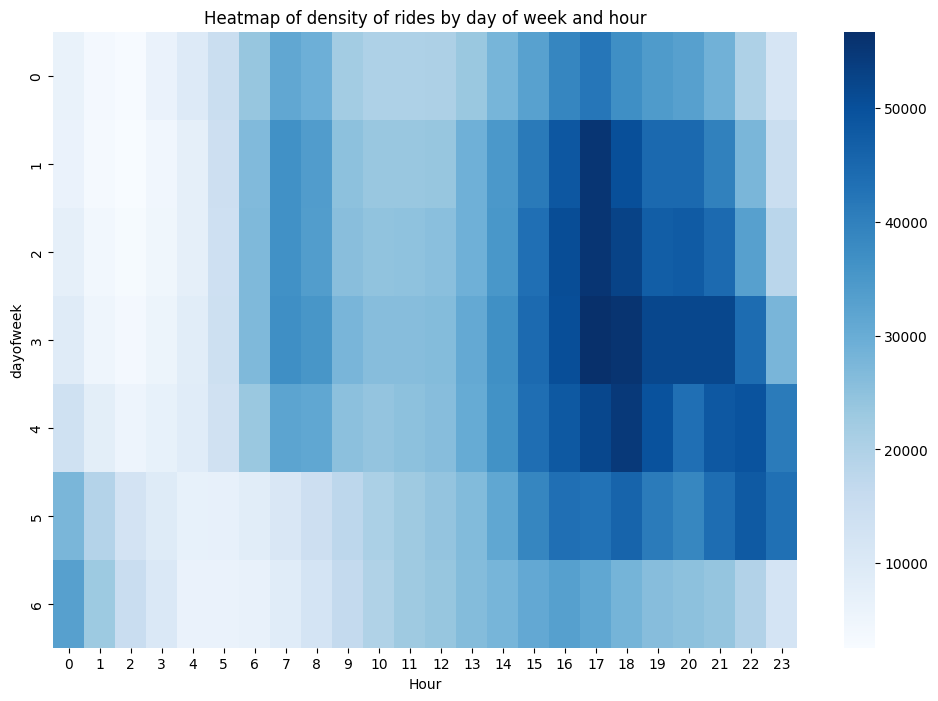

In [9]:
#heatmap of density of rides by day of week and hour
plt.figure(figsize=(12,8))
sns.heatmap(df_uber.groupby(['dayofweek','Hour'])['Date/Time'].count().unstack(), cmap='Blues').set_title('Heatmap of density of rides by day of week and hour')
plt.show()

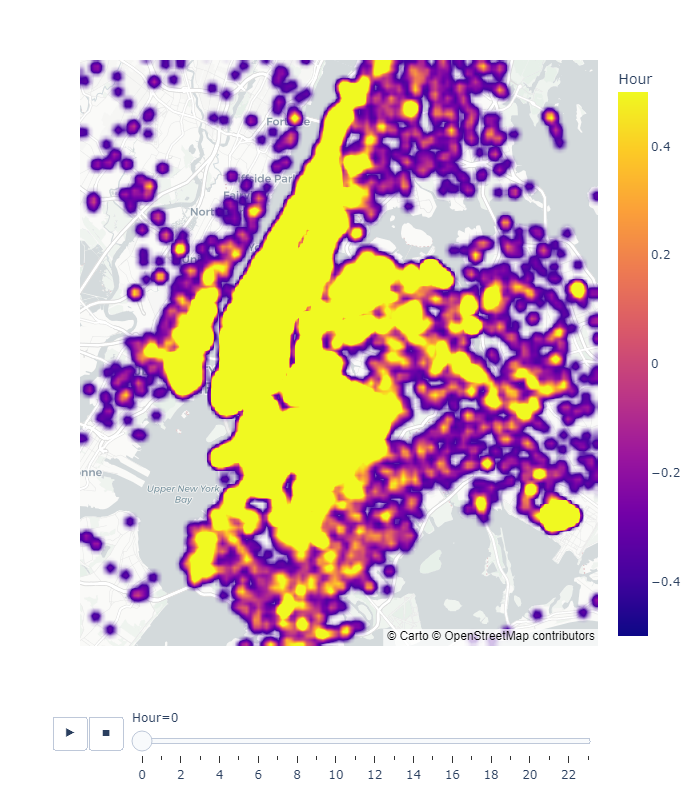

In [10]:
#density mapbox plot of rides animated by hour of the day
fig = px.density_mapbox(df_uber, lat='Lat', lon='Lon', z='Hour', radius=10, animation_frame='Hour', center=dict(lat=40.730610, lon=-73.935242), 
                        zoom=10, mapbox_style='carto-positron', height=800)
fig.show()

# Part2 : Clustering

In [11]:
#preprocessing for clustering
scaler = StandardScaler()
X = scaler.fit_transform(df_uber[['Lat','Lon']])

In [12]:
#sampled data to reduce computation time on local machine
x_sampled = df_uber.sample(n=int((len(df_uber)/20)), weights='Hour', random_state=1)
X_sampled = scaler.fit_transform(x_sampled[['Lat','Lon']])

let's use the within cluster sum of squares (WCSS) to find the optimal number of clusters, it is the sum of the squared distance between each member of the cluster and its centroid. The idea is to minimize the WCSS, so that the data points are clustered as closely as possible to their respective centroids. The code below plots the WCSS values for different numbers of clusters. The elbow method is used to find the optimal number of clusters. The optimal number of clusters is the point after which the WCSS doesn't decrease significantly with every iteration. In the plot below, the optimal number of clusters is 3. The WCSS doesn't decrease significantly after 3.

In [13]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=1)
    kmeans.fit(X_sampled)
    wcss.append(kmeans.inertia_)


c:\Users\swell\OneDrive\Bureau\Data_Science_Fullstack\fullstack-data-certification\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\swell\OneDrive\Bureau\Data_Science_Fullstack\fullstack-data-certification\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\swell\OneDrive\Bureau\Data_Science_Fullstack\fullstack-data-certification\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\swell\OneDrive\Bureau\Data_Science_Fullstack\fullstack-data-certification\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarn

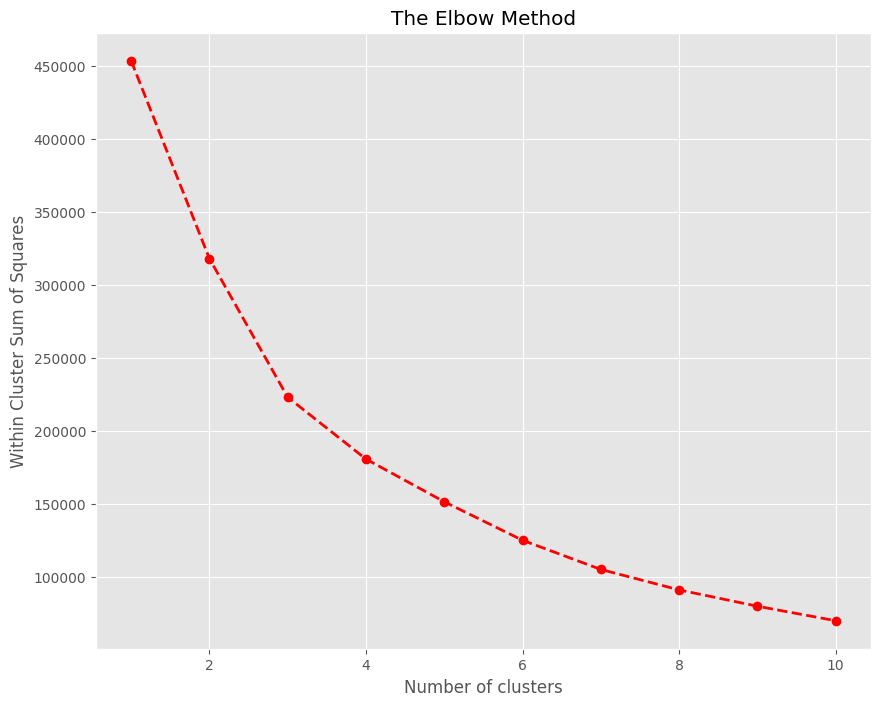

In [14]:
plt.figure(figsize=(10,8))
plt.style.use('ggplot')
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='r', linewidth=2)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

we can see that the elbow method doesn't give us a clear answer. We can see that the curve is not very steep. We can try to use the silhouette score to find the best number of clusters. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters. The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). 

In [15]:
sil = []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 1)
    kmeans.fit(X_sampled)
    silhouette_score(X_sampled, kmeans.predict(X_sampled))[1]


c:\Users\swell\OneDrive\Bureau\Data_Science_Fullstack\fullstack-data-certification\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



KeyboardInterrupt: 

---


In [18]:
#make plotly express figure stick to notebook
from IPython.display import HTML

In [19]:
#gaussian mixture model
gmm = GaussianMixture(n_components=7, random_state=1)
gmm.fit(X)
labels = gmm.predict(X)
df_uber['cluster_gm'] = labels
df_uber['cluster_gm'] += 1

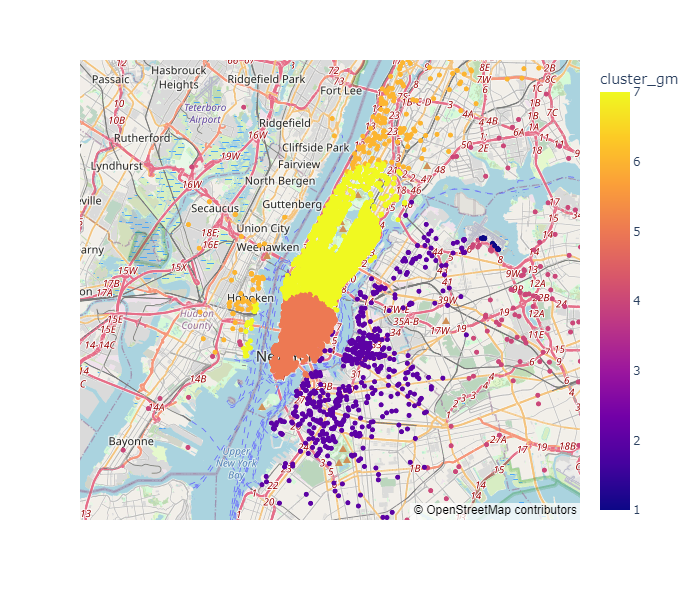

In [20]:
gmm_sample = df_uber.sample(10000, weights='cluster_gm', random_state=1)

fig = px.scatter_mapbox(gmm_sample, lat="Lat", lon="Lon", color="cluster_gm", zoom=10, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

## DBSCAN Clustering Algorithm

In [21]:
#implementing dbscan
dbscan = DBSCAN(eps=0.1,metric='manhattan', min_samples=200)
dbscan.fit(X_sampled)
np.unique(dbscan.labels_,return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64),
 array([ 19146, 171238,  12286,   4615,    506,   9470,   5500,   1227,
          1557,    615,    247,    309], dtype=int64))

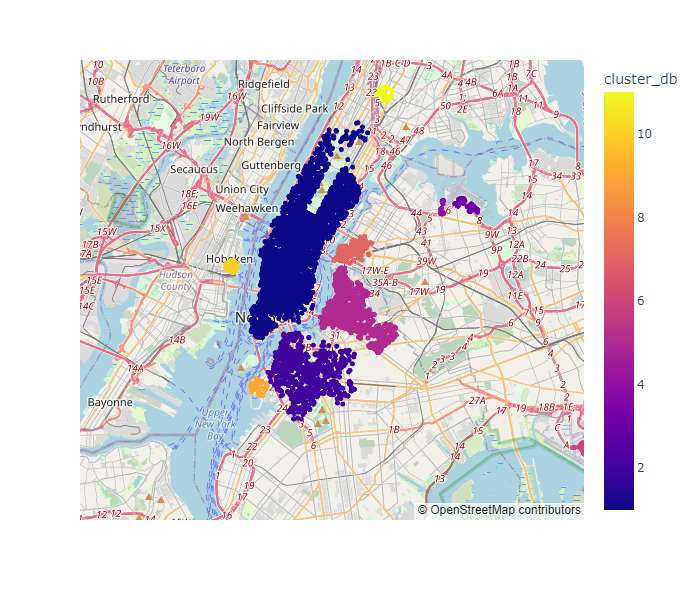

In [22]:
x_sampled['cluster_db'] = dbscan.labels_
x_sampled['cluster_db'] += 1

dbscan_sample = x_sampled.sample(10000, weights='cluster_db', random_state=1)

fig = px.scatter_mapbox(dbscan_sample, lat="Lat", lon="Lon", color="cluster_db", zoom=10, height=600)
fig.update_layout(mapbox_style="open-street-map")
fig.show()

In [23]:
from shapely.geometry import MultiPoint

def top_hotspots_nyc(max_distance,min_pickups,data,hour,day):
    
    sample_data = data[data['Hour']==hour]
    days = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6,'Sunday':7}
    sample_day = days[day]
    sample_data = sample_data[sample_data['Day']==sample_day]
    
    # get coordinates 
    coords = sample_data[['Lat', 'Lon']].to_numpy()
    scaler = StandardScaler()
    x_coords = scaler.fit_transform(coords)

    # Clustering model
    db = DBSCAN(eps=max_distance, min_samples=min_pickups, metric='manhattan').fit(x_coords)
    
    # grouping clusters
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

    # initializing lists for hot spots
    lat = []
    lon = []
    num_members = []
    
    # loop through clusters and get centroids, number of members
    for i in range(len(clusters)):
        # filter empty clusters
        if clusters[i].any():
        # get centroid and magnitude of cluster
            lat.append(MultiPoint(clusters[i]).centroid.x)
            lon.append(MultiPoint(clusters[i]).centroid.y)
            num_members.append(len(clusters[i]))

    #output
    print(f'Number of recommended hot-zones: {num_clusters}')
    #plot on map
    fig = px.scatter_mapbox(lat=lat,lon=lon,
                            color=np.log(num_members),zoom=10,mapbox_style="open-street-map",
                            width=1000,height=800, title=f'Top Hotspot recommendations for NYC on {day} at {hour}:00',
                            labels={'color':'Hotness'})
    #show circles on map around hotspots
    for i in range(len(lat)):
        fig.add_trace(go.Scattermapbox(
            lat=[lat[i]],
            lon=[lon[i]],
            mode='markers',
            marker=go.scattermapbox.Marker(
                size=50,
                color=np.log(num_members[i]),
                opacity=0.4
            ),
            text=[f'Hotspot {i+1}'],
        ))
        #hide legend for traces
        fig.data[-1].showlegend = False
    
    fig.show()

In [24]:
max_distance = 0.15
min_pickups = 10
hour = 17
day = 'Saturday'

Number of recommended hot-zones: 14


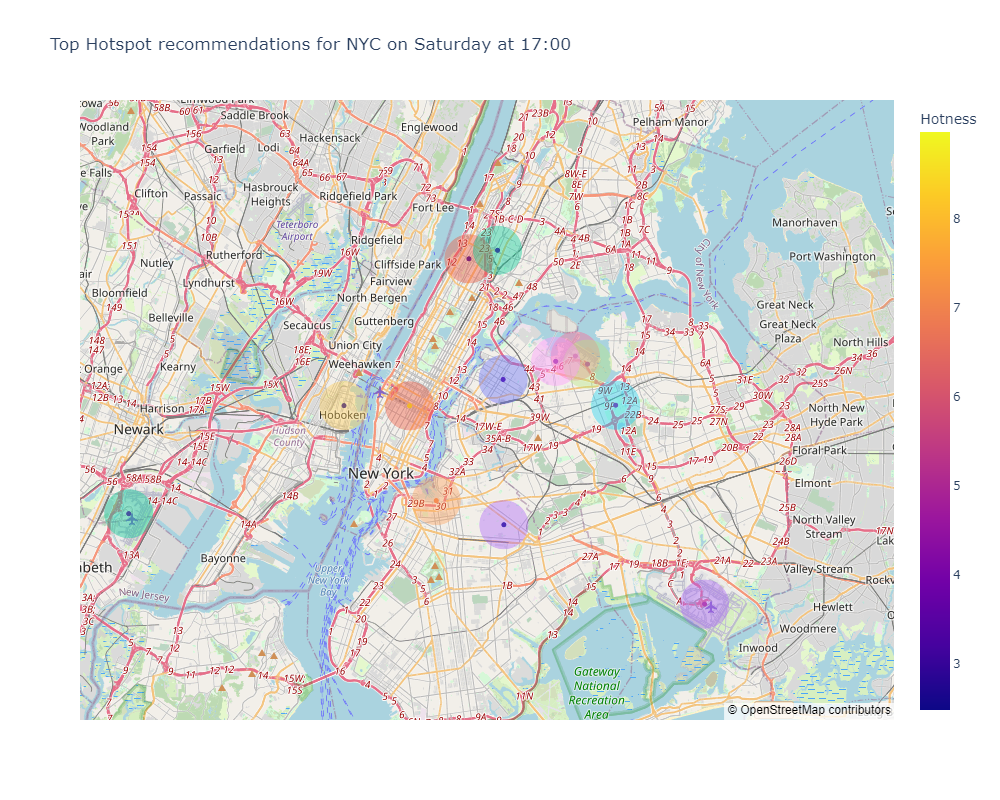

In [25]:
top_hotspots_nyc(max_distance,min_pickups,df_uber,hour,day)